In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree

In [2]:
pd.set_option("display.max_columns", None)

# Read in data

In [3]:
frames = pd.read_csv('../data/train.csv', usecols=['GameId','HomeTeamAbbr','PlayId','Team','PossessionTeam','FieldPosition','X','Y','S','A','Dis','Dir','NflId','DisplayName','Season','YardLine','NflIdRusher','PlayDirection','Yards'])

In [4]:
frames.shape

(682154, 19)

In [5]:
frames.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Dir,NflId,DisplayName,Season,YardLine,PossessionTeam,FieldPosition,NflIdRusher,PlayDirection,Yards,HomeTeamAbbr
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,177.18,496723,Eric Berry,2017,35,NE,NE,2543773,left,8,NE
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,198.70,2495116,Allen Bailey,2017,35,NE,NE,2543773,left,8,NE
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,202.73,2495493,Justin Houston,2017,35,NE,NE,2543773,left,8,NE
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,105.64,2506353,Derrick Johnson,2017,35,NE,NE,2543773,left,8,NE
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,164.31,2530794,Ron Parker,2017,35,NE,NE,2543773,left,8,NE


# Transform Data

In [6]:
map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
for abb in frames['PossessionTeam'].unique():
    map_abbr[abb] = abb

In [7]:
frames['PossessionTeam'] = frames['PossessionTeam'].map(map_abbr)
frames['HomeTeamAbbr'] = frames['HomeTeamAbbr'].map(map_abbr)

In [8]:
frames['IsRusher'] = (frames['NflId'] == frames['NflIdRusher']).astype(int)

In [9]:
def touchdown_distance(row):
    return (100 - row['YardLine']) if (row['PossessionTeam'] == row['FieldPosition']) else row['YardLine']
    
frames['YardsToTouchdown'] = frames.apply(touchdown_distance, axis=1)
frames.drop('YardLine', axis=1, inplace=True)

In [10]:
frames.loc[frames.Season == 2017, 'S'] = 10*frames.loc[frames.Season == 2017,'Dis']
frames.drop('Dis', axis=1, inplace=True)

In [11]:
def is_offensive_player(team, poss_team, home_team):
    if team == 'away':
        if poss_team != home_team:
            return 1
        else:
            return 0
    else:
        if poss_team == home_team:
            return 1
        else:
            return 0

frames['OffensivePlayer'] = frames[['Team','PossessionTeam','HomeTeamAbbr']].apply(lambda x: is_offensive_player(x[0],x[1],x[2]), axis=1) 

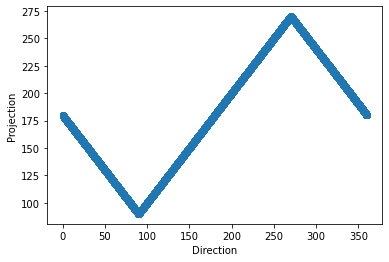

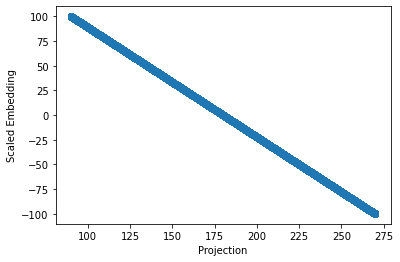

In [12]:
frames['PlayLeft'] = (frames['PlayDirection'] == 'left').astype(int)

# the field is 120 yards in the x direction and 53.3 in the y direction
# the lower left corner is (0,0)
# the lower right corner is (120,0)
# the upper left corner is (0,53.3)
# the upper right corner is (120,53.3)
# if a play is going left we want to reorient to go right
# basically all of our plays should be going in the same direction
# changing up X and Y is rather simple as we just flip our coordinates
# for example, if a play is going left and the X is at 80 that just means
# we need to reorient the play right at the 40 yard line (120 - 80 = 40)
# similarly done across the field with regard to it being 53.3 yards wide
frames['X_std'] = frames['X']
frames.loc[frames.PlayLeft == 1, 'X_std'] = 120 - frames.loc[frames.PlayLeft == 1, 'X']

frames['Y_std'] = frames['Y']
frames.loc[frames.PlayLeft == 1, 'Y_std'] = 53.3 - frames.loc[frames.PlayLeft == 1, 'Y']

# direction is a bit more complicated
# it's a little easier to think about it in terms of
# a rusher going up the field vs backwards and left vs right
# we are making sure all plays are oriented from left to right
# so we have to convert the 0-360 degree orientation of plays
# going left to correspond to the newly flipped orientation going right.

# For plays going left we have to add 180 degrees to the Dir field for rushes going backwards
# and subtract 180 degrees to the Dir field for plays going forwards
# As an example, if a play is going left and the rusher runs backwards to his right at 45 degrees
# that needs to get converted from 45 degrees to 225 degrees. This corresponds to a rusher going
# backwards and to his right in the orientation going from left to right down the field.
# On the other hand, for a play going left and the rusher going forward and to his left at 225 degrees
# needs to get converted to 45 degrees to mark the new orientation going forward and left in the new rightly direction.
frames.loc[(frames.PlayLeft == 1) & (frames.Dir < 180), 'Dir_std'] = frames.Dir + 180
frames.loc[(frames.PlayLeft == 1) & (frames.Dir >= 180), 'Dir_std'] = frames.Dir - 180
# plays going right don't change direction orientation
frames.loc[frames.PlayLeft == 0, 'Dir_std'] = frames.Dir
# we need to fill in the 28 missing Dir records
frames['Dir_std'] = frames['Dir_std'].fillna(np.mean(frames['Dir_std']))

# I want to explore a system for linerally relating the direction
# to some sort of numeric embedding. I came up with a -100 to 100
# embedding where a runner moving directly backwards (Dir of 270 degrees)
# receives an embedding of -100 and a rusher moving directly forward (Dir of 90 degrees)
# receives an embedding of +100. The embedding of 0 represents a rusher either moving
# directly left or right, but not backwards or forwards (Dir of 0, 180 or 360 degrees)
# In this system a rusher moving slightly forward to the left is measured equally
# as a rusher moving slightly forward to the right. So we need to project
# 360 to 180, 315 to 225 and everything between.
# The same goes for projecting 0 to 180, 45 to 135 and everything between.
def direction_projection(d):
    if d > 270:
        return 540 - d
    elif (d >= 90) and (d <= 270):
        return d
    elif d < 90:
        return 180 - d
    else:
        return None

# Now we have a projection with a range of 90 to 270 inclusive and 
# can transform it in the range from -100 to +100 inclusive where
# negative values represent rushers moving backwards and 
# positive values represent rushers moving forwards.
def direction_transformer(d):
    if d < 90:
        return d/0.90
    elif d < 270:
        return (180 - d)/0.90
    elif d <= 360:
        return (d - 360)/0.90
    else:
        return None
    
frames['Dir_projected'] = frames['Dir_std'].apply(lambda x: direction_projection(x))
frames['Dir_scaled'] = frames['Dir_projected'].apply(lambda x: direction_transformer(x))

plt.scatter(frames.Dir_std, frames.Dir_projected)
plt.xlabel('Direction')
plt.ylabel('Projection')
plt.show()

plt.scatter(frames.Dir_projected, frames.Dir_scaled)
plt.xlabel('Projection')
plt.ylabel('Scaled Embedding')
plt.show()

# Create Features

### KNN Yard Features

I will build a KD-Tree on rusher features and identify most similar other rushing attempts based on features. I will then extract yard information from these most similar attempts as new features.

In [13]:
rusher_X = frames[frames['IsRusher'] == 1][['GameId','PlayId','X_std','Y_std','S','A','Dir_scaled','YardsToTouchdown','Yards']].reset_index(drop=True)

In [14]:
tree = KDTree(rusher_X.iloc[:, 2:-1])

In [15]:
dist, ind = tree.query(rusher_X.iloc[:, 2:-1], k=10)

In [16]:
mins = []
avgs = []
maxs = []
stds = []
for indx, row in rusher_X.iterrows():
    similar_records = rusher_X.iloc[ind[indx][1:], :]
    
    min_yards = similar_records.Yards.min()
    avg_yards = similar_records.Yards.mean()
    max_yards = similar_records.Yards.max()
    std_yards = similar_records.Yards.std()
    
    mins.append(min_yards)
    avgs.append(avg_yards)
    maxs.append(max_yards)
    stds.append(std_yards)

In [17]:
rusher_X['min_similar_yards'] = mins
rusher_X['avg_similar_yards'] = avgs
rusher_X['max_similar_yards'] = maxs
rusher_X['std_similar_yards'] = stds

In [18]:
rusher_X.drop('Yards', axis=1, inplace=True)

In [19]:
rusher_X.head()

,GameId,PlayId,X_std,Y_std,S,A,Dir_scaled,YardsToTouchdown,min_similar_yards,avg_similar_yards,max_similar_yards,std_similar_yards
0,2017090700,20170907000118,41.25,22.77,3.8,3.35,73.044444,65,1,3.555556,6,1.740051
1,2017090700,20170907000139,48.93,26.14,3.4,2.41,53.111111,57,0,6.000000,25,8.276473
2,2017090700,20170907000189,71.34,34.19,6.0,2.42,46.622222,35,1,4.000000,11,3.082207
3,2017090700,20170907000345,104.47,27.94,4.6,3.20,93.955556,2,-2,0.111111,1,1.269296
4,2017090700,20170907000395,29.99,27.12,4.4,2.53,24.533333,75,-3,4.888889,12,4.935698


In [20]:
rusher_X.to_csv('../data/rusher_features.csv', header=True, index=False)

#### Let's now consider defensive distances from rusher

In [21]:
%%time
defensive_distances = np.zeros((rusher_X.shape[0], 11))
defensive_speeds = np.zeros((rusher_X.shape[0], 11))
defensive_accel = np.zeros((rusher_X.shape[0], 11))
defensive_dir = np.zeros((rusher_X.shape[0], 11))
for indx, row in rusher_X[['GameId','PlayId','X_std','Y_std','S','A','Dir_scaled']].iterrows():
    rusherX = row['X_std']
    rusherY = row['Y_std']
    rusherS = row['S']
    rusherA = row['A']
    rusherDir = row['Dir_scaled']

    # filter down to defensive players
    mask = (frames['GameId'] == row['GameId']) & \
           (frames['PlayId'] == row['PlayId']) & \
           (frames['OffensivePlayer'] == 0) & \
           (frames['IsRusher'] == 0)
    defensive_players = frames[mask][['X_std','Y_std','S','A','Dir_scaled']]

    # calculate euclidean distance between rusher and each defensive player
    rusher_point = np.array([rusherX, rusherY])
    defensive_points = defensive_players[['X_std','Y_std']].values
    distances = np.linalg.norm(rusher_point - defensive_points, axis=1)
    
    # difference in speed between rusher and defensive players
    speeds = rusherS - defensive_players[['S']].values
    
    # difference in acceleration between rusher and defensive players
    accels = rusherA - defensive_players[['A']].values
    
    # difference in direction between rusher and defensive players
    dirs = rusherDir + defensive_players[['Dir_scaled']].values
    
    # zip features since we will sort based on distance
    zipped = zip(distances, speeds, accels, dirs)

    # sort the distances from closest to furthest
    sorted_feats_by_distances = sorted(zipped, key=lambda x: x[0])

    # append to array
    defensive_distances[indx] = [x[0] for x in sorted_feats_by_distances]
    defensive_speeds[indx] = [x[1] for x in sorted_feats_by_distances]
    defensive_accel[indx] = [x[2] for x in sorted_feats_by_distances]
    defensive_dir[indx] = [x[3] for x in sorted_feats_by_distances]

Wall time: 9min 22s


In [22]:
feats = np.stack([defensive_distances, defensive_speeds, defensive_accel, defensive_dir], axis=2)
feats.shape

(31007, 11, 4)

In [23]:
np.save(file='../data/rusher_vs_defensive_features', arr=feats)

# Extract Play's Yard Outcome

In [24]:
play_outcomes = frames[['GameId','PlayId','Yards']].drop_duplicates()

In [25]:
play_outcomes.to_csv('../data/yard_outcomes.csv', header=True, index=False)